Transformer及其衍生架构，在自然语言处理上取得了卓越的成果。但是，在将这一范式迁移到时间序列预测上来的时候，却遇到了尴尬的打不过线性模型的困难

首先我们分析一下，NLP（自然语言处理）和TSF（时间序列预测）两个问题的主要差别：

1. 自然语言中的语义既存在在每个单词中，也存在在单词之间的序列关系上。一个句子完全打乱单词顺序，也能保留部分信息（尽管不那么准确）。一个还不懂语法的语言学习者，仅靠单词也可以和其他人勉强交流。但是对于时间序列，打乱顺序就意味着完全丢失信息，可以说时间序列的信息绝大部分都隐藏在序列之中。

2. 自然语言的具有高度的一致性和可迁移性，常见单词和词组的含义在绝大多数语料中都是相近相似的，虽然会有一些多义词但毕竟是少数。而不同的时间序列即使出现了相同的形态，也不能说就有相似含义。例如，在金融领域，某些价格形态会包含价格趋势信息，其底层的逻辑是多空双方的博弈导致的，但是如果这样的形态出现在例如气温序列中，就不能说表示趋势性，因为底层的逻辑完全不一样。

3. 自然语言的训练集非常丰富，在人类历史上积累了大量的训练语料。但由于时间序列的含义差距，每个领域的时间序列是有限的，只能使用当前研究的框架内的数据。一般资产的数据有10年以上已经是非常丰富的历史了。如果扩展序列就会面临结构和范式的变化。

4. 自然语言的模式迁移非常缓慢，几乎可以忽略不记，虽然人类的语言会有所发展和变化，但是这种变化都是以数十年为单位的，在短期内改变的只会有少数词的词义，大的语法是不会改变的。但对于金融数据。概念漂移是非常常见的，时间序列的底层因素，例如次贷危机、疫情的出现很可能直接导致资产的模式完全改变，从而让历史数据的价值大打折扣，进一步加剧了数据量的问题。

Transformer架构能在NLP上取得成功的原因，恰恰也是Transformer架构不能被直接迁移到TSF上的原因：

1. RNN架构的顺序结构会影响长距离信息传递，长距离信息要么随着梯度消失，要么产生梯度爆炸。为了能顺利捕捉长距离关系，Transformer架构可以放弃了RNN架构的顺序性，转而使用并行性保护远距离信息可以顺利传播；

2. 因为采用了并行架构丢失了顺序信息，Transformer架构采用位置编码补齐丢失的顺序信息。但位置编码会影响一部分原始语义信息；

3. 因为训练语料足够丰富，导致位置编码的影响可以被最小化；

4. 平行架构也可以充分运用算力，大幅度加速训练过程，因此可以接受更复杂的模型层数。将牺牲的部分通过更大的模型来弥补。

换言之，因为自然语言的训练资料足够丰富，足以掩盖Transformer架构的缺点，充分发挥Transformer架构的优势，才使得Transformer架构得以在NLP问题上大放异彩。但反过来，在TSF问题上，Transformer架构并没有这样的优势。而其劣势，会被时间序列数据量缺乏的问题放大。Transformer架构本身就很复杂，模型的参数量越大，需要的数据集也就越大，超大的模型可以轻松记忆本就为数不多的数据集导致过拟合，必须对扩展模型保持谨慎态度。

当然，这也并不意味着完全就不能使用Transformer架构。Transformer架构在长距离提取上仍然有优势。具体来说，如果想要充分发挥Transformer架构的优势，我们需要解决如下问题：

1. 每个信息单元包含的信息要足够丰富。自然语言中每个单词的语义已经非常丰富，最新的的大语言模型单个词嵌入维度已经达到了4096甚至更高。而单个时间步的OHLCV数据的维度太小，即使扩展一些辅助信息，也很难从单个时间步得到有效信息进行相互传播。因此，单个信息单元要从时间步提升到子序列级别，比如一个长达10天的子序列，除了10天本身的价格信息以外，还能抽象出某种趋势信息，例如一小段缩量上涨、或者一小段区间的放量震荡等等。通过将多个时间步组合成一个patch的方式，模型可以变为处理一段一段的时间。同时，这样的结构也可以接入更长的历史窗口，绕开Transformer在注意力层的O(N^2)复杂度的限制。

2. 用科学的方式扩展训练集，如果我们的目标是资产价格预测，那么至少训练集的范围可以扩展到其他金融资产，但不应该扩展到非金融的领域。因为价格的底层逻辑是供需关系、多空博弈。同时，还要增加额外的机制让模型理解不同资产之间的差距和联系，例如波动率、相关性、协整性等等。



In [246]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [247]:
class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            # nn.Linear(self.num_patch * d_model, self.num_patch * d_model),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.0,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]


        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output
        


In [248]:
# 这些参数是两阶段共享的
seq_len = 160
patch_size = 5

num_layer = 4
num_head = 4
d_model = 256

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]

stride = patch_size // 2 # 50% overlap
masking_ratio = 0.2 
mask_expand_size = 1


# 这些参数是可变的
dropout_1 = 0.5
dropout_2 = 0.05
dropout_3 = 0.2

learning_rate = 0.0004063346203116716
weight_decay = 0.0009988629575338828


In [249]:
# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] < 20230901].copy() # 所有2023年以后数据不参与训练
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)

feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]

feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)

data = RandomLoader(feature, label)
recorder = PredictionRecorder()
animator = TrainMonitor(figsize=(12,6))

In [250]:
# train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.2], balance=[True, False])
# for x, y in test_loader:
#     print(y.shape)

In [251]:
# 二阶段 prediction训练
def objective(trial):
   # 模型结构的全局参数，不可修改
    seq_len = 160
    patch_size = 8
    num_layer = 5
    num_head = 4
    d_model = 256
    assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']
    # assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
    stride = 4 # patch_size // 2  奇数再(+1)
    masking_ratio = 0.2
    mask_expand_size = 1

    # 前置层相关（冻结）
    dropout_1 = 0
    dropout_2 = 0
    learning_rate_encoder = 0
    weight_decay_encoder = 0

    # 训练相关
    batch_size = 256

    # 输出层相关
    dropout_3 = trial.suggest_float("dropout_3", 0.0, 0.5)
    learning_rate_output = trial.suggest_float("learning_rate_output", 1e-10, 1e-1, log=True)
    weight_decay_output = trial.suggest_float("weight_decay_output", 1e-6, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-2, 1e-1, log=True)
    delta = trial.suggest_float("delta", 1.0, 1.3)
    gamma = trial.suggest_float("gamma", 0.7, 1, log=True)


    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']

    feature = []
    label = []
    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        data = data[data['trade_date'] < 20230901].copy()
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    data = RandomLoader(feature, label)


    precision_list = []

    for i in range(10):
        animator.reset()
        train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.7,0.2], balance=[True, True])

        model = Patch_TST(input_size = 10,
                        seq_len = seq_len,
                        patch_size = patch_size,
                        stride = stride,
                        num_layer = num_layer, 
                        num_head = num_head,
                        d_model = d_model,
                        masking_ratio = masking_ratio,
                        mask_expand_size = mask_expand_size,
                        dropout_1 = dropout_1,
                        dropout_2 = dropout_2,
                        dropout_3 = dropout_3,
                        ).to('cuda:0')
        model.load_state_dict(torch.load('params/self_supervised_1.params'))

        # 对预训练部分设置不同学习率
        output_params = model.output.parameters()
        output_param_ids = {id(p) for p in output_params}
        other_params = [p for p in model.parameters() if id(p) not in output_param_ids]
        optimizer_grouped_parameters = [
                {'params': other_params, 'lr': learning_rate_encoder, 'weight_decay': weight_decay_encoder},
                {'params': model.output.parameters(), 'lr': learning_rate_output, 'weight_decay': weight_decay_output}
            ]

        optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)
        train = ModelTrain(model = model, train_loader = train_loader, test_loader = test_loader, loss_fn = loss_fn, optimizer = optimizer, scheduler = scheduler, recorder = recorder,graph = animator)

        prediction, precision = train.epoch_train(epochs = 10, early_stop = 100)
        precision_list.append(precision)
    
    return np.mean(precision_list)/np.std(precision_list)

In [252]:
# study = optuna.create_study(
#     direction="maximize",
#     # study_name="patchtstprediction",
#     # storage="sqlite:///data/db.sqlite3_prediction",  # 保存到 SQLite 文件
#     # load_if_exists=True # 如果存在同名study，则加载它
# )

# study.optimize(objective, n_trials=30)
# print("最佳准确率: ", study.best_value)
# print("最佳超参数: ", study.best_params)
# df = study.trials_dataframe()
# df.sort_values(by='value', ascending=False)

In [253]:
# df.sort_values(by='value', ascending=False)

In [254]:
# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()

In [255]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.show()

In [256]:
# df.sort_values(by='value', ascending=False)

最佳超参数:  {'batch_size ': 256, 'dropout_3': 0.2, 'learning_rate_output': 1e-4, 'weight_decay_output': 1e-4}

最佳准确率:  4.177628846327211
最佳超参数:  {'batch_size ': 64, 'dropout_3': 0.16302522951448722, 'learning_rate_output': 0.0002574122864472939, 'weight_decay_output': 0.0004618348719819646}

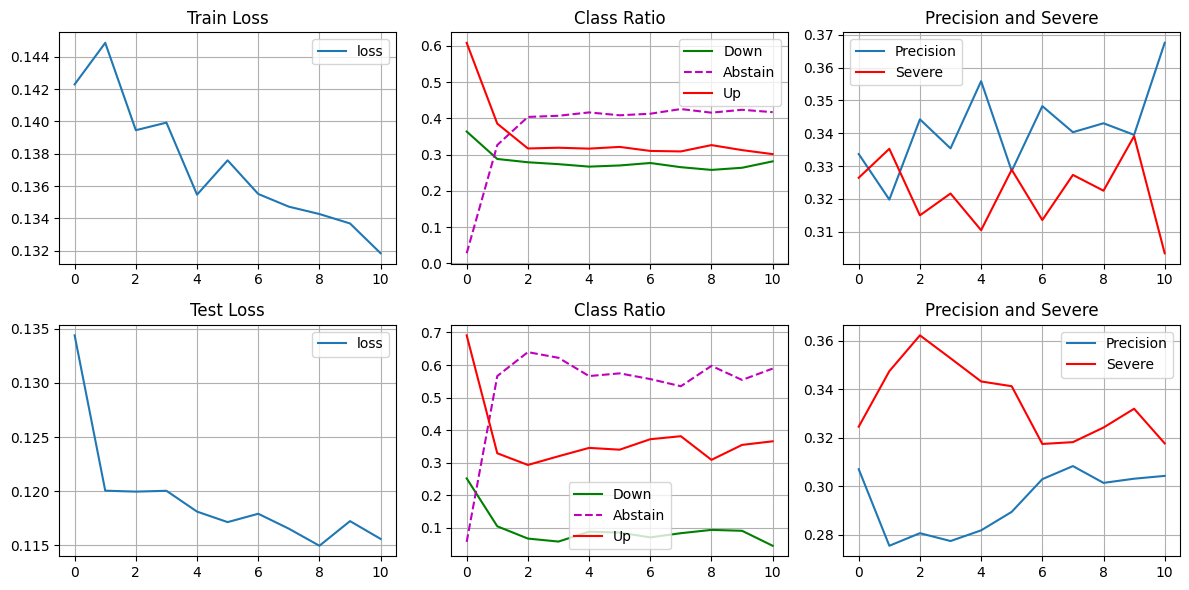

100%|██████████| 34/34 [00:00<00:00, 145.74it/s]


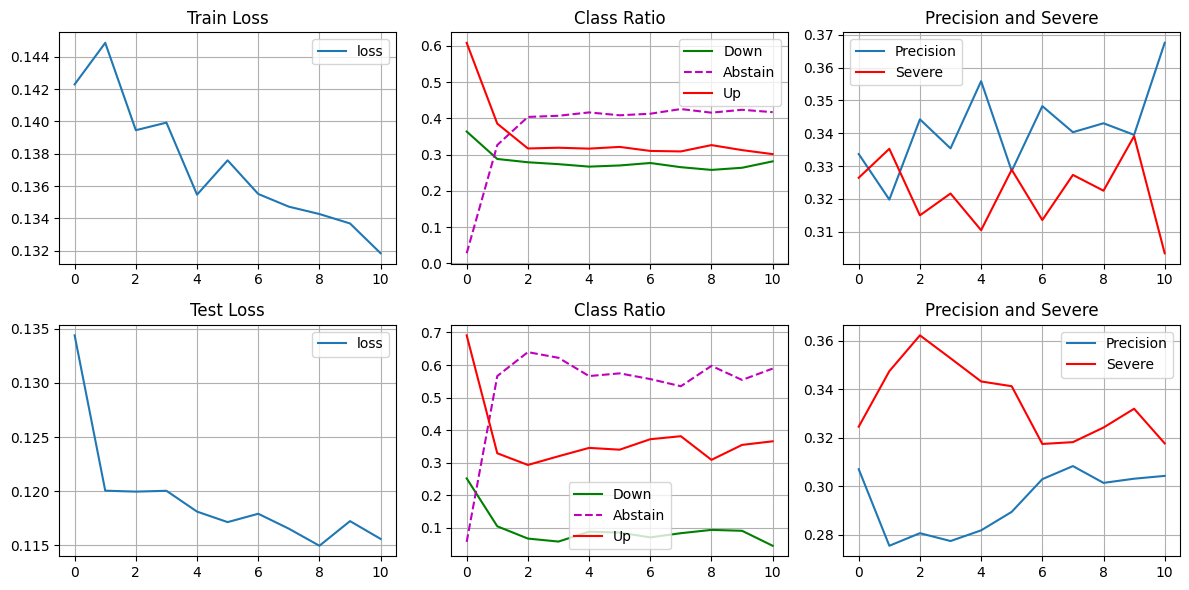

In [257]:
# 只训练输出层
# 模型结构的全局参数，不可修改
seq_len = 160
patch_size = 8
num_layer = 5
num_head = 4
d_model = 256
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
stride = 4 # patch_size // 2  奇数再(+1)
masking_ratio = 0.2
mask_expand_size = 1

# 前置层相关（冻结）
dropout_1 = 0
dropout_2 = 0
learning_rate_encoder = 0 # 不要超过1e-10 否则会破坏pretrain，因为pre train的transformer记忆力很强，很容易过拟合，必须限制在二阶段记忆模型，设为0其实效果更好
weight_decay_encoder = 0

# 训练相关
batch_size = 32

# 输出层相关
dropout_3 = 0.3
learning_rate_output = 1e-6 # 1e-6
weight_decay_output = 0 #1e-5
alpha = 0.01
delta = 1.3


# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] < 20230901].copy() # 所有2023年以后数据不参与训练
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)

train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.2], balance=[True, True])

model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')
model.load_state_dict(torch.load('params/self_supervised_1.params'))
zero_bias = torch.tensor([0.0, 0.0, 0.0], device = 'cuda:0')
model.output[2].log_prob[0].bias.data = zero_bias

# 对预训练部分设置不同学习率
output_params = model.output.parameters()
output_param_ids = {id(p) for p in output_params}
other_params = [p for p in model.parameters() if id(p) not in output_param_ids]
optimizer_grouped_parameters = [
            {'params': other_params, 'lr': learning_rate_encoder, 'weight_decay': weight_decay_encoder},
            {'params': model.output.parameters(), 'lr': learning_rate_output, 'weight_decay': weight_decay_output}
        ]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)
train = ModelTrain(model = model, train_loader = train_loader, test_loader = test_loader, loss_fn = loss_fn, optimizer = optimizer, scheduler = scheduler, recorder = recorder, graph = animator)

prediction, precision = train.epoch_train(epochs = 10, early_stop = 100)

torch.save(model.state_dict(), 'params/supervised_1.params')


In [258]:
# all_assets = pd.DataFrame({
#     'stage_1_prediction': np.mean(result, axis = 0)[:,0],
#     'stage_2_prediction': np.mean(result, axis = 0)[:,2],

#     'stage_1_precision': np.mean(result, axis = 0)[:,1],
#     'stage_2_precision': np.mean(result, axis = 0)[:,3],

#     'stage_1_precision_std': np.std(result, axis = 0)[:,1],
#     'stage_2_precision_std': np.std(result, axis = 0)[:,3],
# })
# # all_assets.index = pd.Series(assets_list)
# for col in all_assets.columns:
#     all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# # 转换为Markdown
# markdown_table = all_assets.to_markdown(index=False)
# print(markdown_table)